In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import src.models
import src.spectrograms as spec
import src.utils
import scipy.signal

In [2]:
file_name  = "take-five"
audio_file = f"data/{file_name}.wav"
midi_file  = f"data/{file_name}.mid"
waveform, sample_rate = torchaudio.load(audio_file)

# Convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
    waveform = waveform.squeeze(0)

## Getting the spectrogram

### STFT Spectrogram

In [3]:
n_fft           = 1024
hop_length      = 512
min_mag         = 1e-5

spec_stft, spec_np, times_stft, freq_stft = spec.stft_spec(waveform, sample_rate, n_fft, hop_length, min_mag)

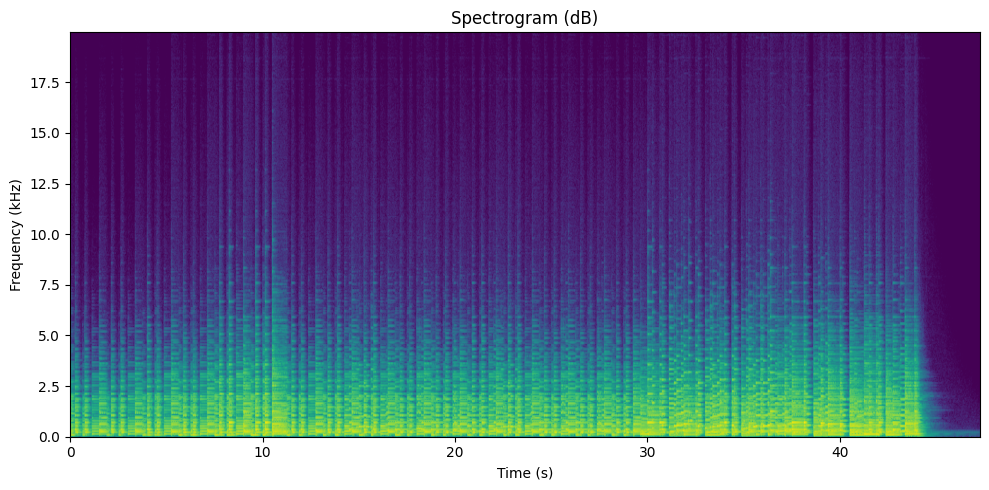

In [4]:
min_freq = 0
max_freq = 20*1e3

spec.vis_spectrogram(spec_stft, times_stft, freq_stft, 0, times_stft[-1], min_freq, max_freq)

Folding over in the 22-25 kHz range due to the sample rate (48kHz)

$\to$ Applying a lowpass filter to attenuate it (attenuate everything over $\frac{sample\_rate}{2}$)

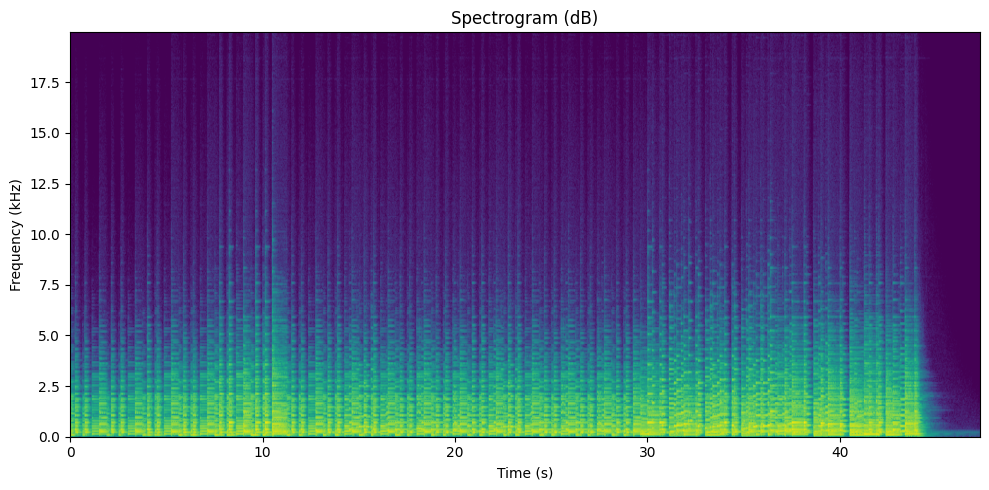

In [5]:
cutoff_freq = 21000
nyquist_rate = sample_rate / 2
normalized_cutoff = cutoff_freq / nyquist_rate
order = 4
b, a = scipy.signal.butter(order, normalized_cutoff, btype='low')
filtered_waveform = torch.tensor(scipy.signal.lfilter(b, a, waveform.numpy(), axis=-1))

filtered_spec, filtered_spec_np, times, frequencies = spec.stft_spec(filtered_waveform, sample_rate, n_fft, hop_length, min_mag)
spec.vis_spectrogram(filtered_spec_np, times, frequencies, 0, times_stft[-1], min_freq, max_freq)

### CQT Spectrogram

In [6]:
n_fft           = 1024
hop_length      = 128

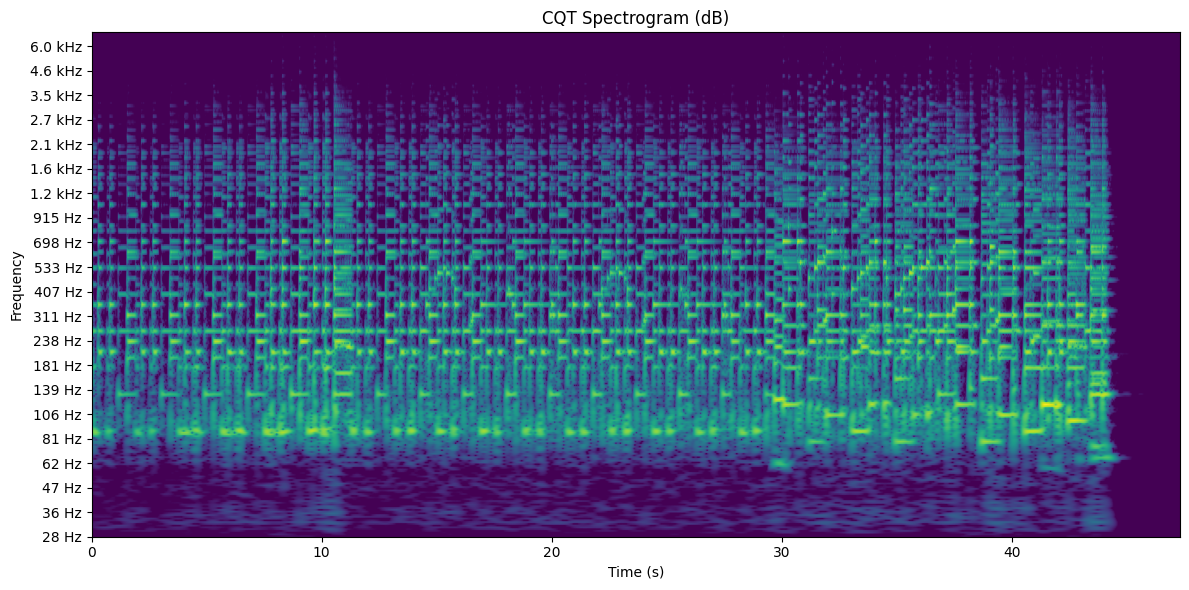

In [7]:
spec_cqt, times_cqt, freq_cqt = spec.cqt_spec(waveform, sample_rate, hop_length)
spec.vis_cqt_spectrogram(spec_cqt, times_cqt, freq_cqt, 0, times_cqt[-1])

### ERB Spectrogram

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_env/lib/python3.9/site-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


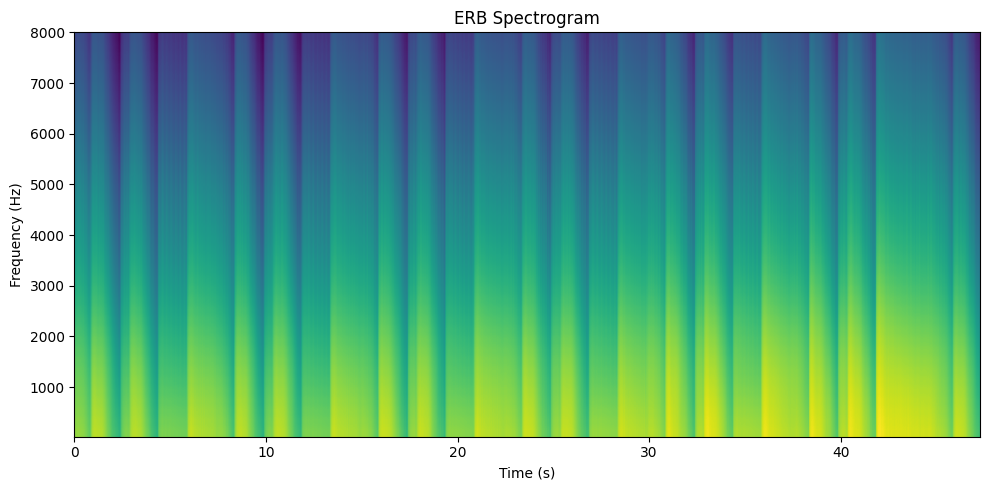

In [8]:
spec_erb, times_erb, freqs_erb = spec.erb_spec(waveform, sample_rate, hop_length=hop_length)
spec.vis_erb_spectrogram(spec_erb, freqs_erb, times, start=0, stop=times[-1])

### GroundTruth midi file

tensor([ 1.1921e-07,  1.3649e-05,  3.8803e-05,  ..., -5.7220e-06,
        -5.9605e-06, -6.1989e-06])


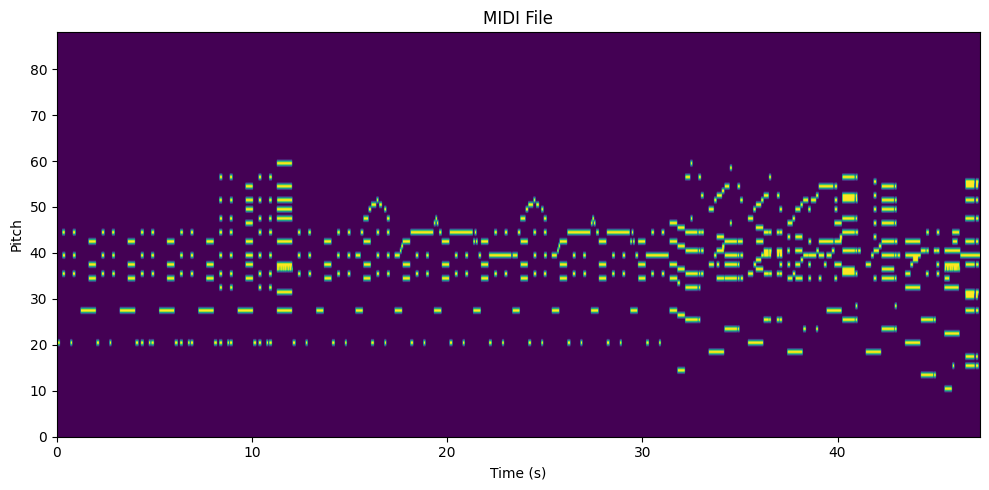

In [9]:
midi_path = "data/take-five.mid"
midi, times_midi = spec.midi_to_pianoroll(midi_path, waveform, spec_stft.shape[1], hop_length, sample_rate)
spec.vis_midi(midi, times_midi, 0, times_midi[-1])

## Unrolled NMF

M ≈ WH 

**M** : CQT spectrogram (`spec_cqt`), **W** : dictionnary of notes, **H** : notes activations, **l** : number of different notes to detect

In [10]:
# Init
M           = spec_cqt
n_sources   = 4
l           = n_sources*88
f           = M.shape[0]
t           = M.shape[1]
n_iter      = 1

In [11]:
print(f"input spectrogram: {M.shape}")
print(f"number of notes to be split: {l}")
print(f"number of frequency bins: {f}")
print(f"number of time bins: {t}")

input spectrogram: (288, 17743)
number of notes to be split: 352
number of frequency bins: 288
number of time bins: 17743


### Iterative MU
Requires pretrained Aw and Ah

In [12]:
W, H, M_hat = src.models.MU_iter(M, l, f, t, n_iter)

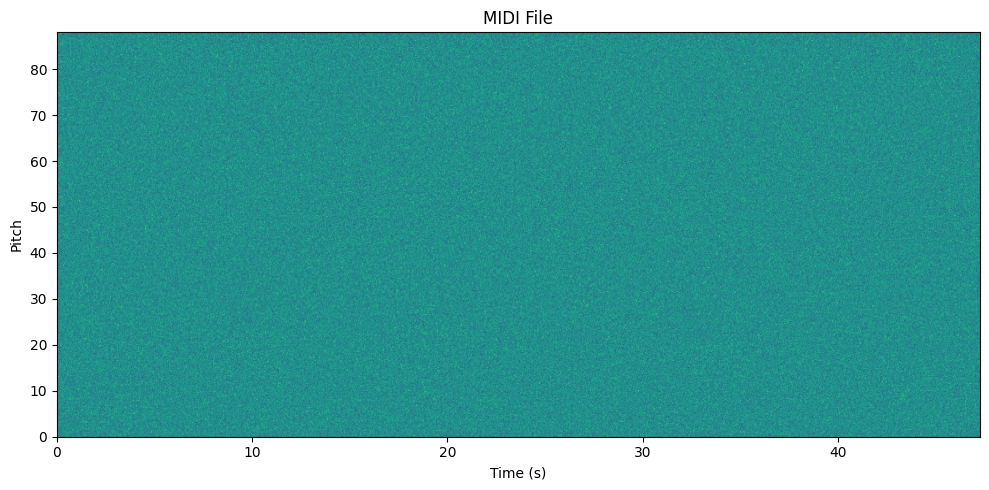

In [13]:
spec.vis_midi(H[-1,:,:].detach().numpy(), times, times_cqt[0], times_cqt[-1])

### Unrolled RALMU

In [14]:
eps     = 1e-5
# W = src.models.init_W_H("path/to/Wdata", hop_length)
model   = src.models.RALMU(f, t, l=l, n_iter=n_iter, shared=True, eps=eps)
device  = torch.device('cpu')
model.to(device=device)

RALMU(
  (layers): ModuleList(
    (0): RALMU_block2(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (relu): ReLU()
        (sigmoid): Sigmoid()
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(32, 1, kernel_size=(1,), stride=(1,), padding=(1,))
        (relu): ReLU()
        (sigmoid): Sigmoid()
      )
    )
  )
)

In [15]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

13250

- **Load** the dataset

In [16]:
dataset = src.utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
for M, H in loader:
    print(f"M shape: {M.shape}")
    # print(f"H shape: {H.shape}")

- **Train** the model

In [20]:
n_epochs    = 2
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-5)

In [21]:
loss = src.utils.train(n_epochs, model, optimizer, loader, device)

plt.plot(loss)
plt.ylabel("Total loss")
plt.xlabel("Epochs")

CQT spectrogram shape: torch.Size([2049, 4543])


AttributeError: 'int' object has no attribute 'shape'